<a href="https://colab.research.google.com/github/TharinsaMudalige/Neuron-Brain_Tumor_Detection_Classification_with_XAI/blob/Detection-Classification-VIT/Tumor_Classification_Hybrid_Model_(ViT_and_CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models

Load the preprocessed dataset

In [2]:
# Define the dataset directory
base_dir = "/content/drive/MyDrive/Colab Notebooks/Preprocessed_Dataset_classification"

EDA

In [ ]:
# Exploratory Data Analysis (EDA)
def perform_eda(images, labels, class_names):
    """Perform EDA on the dataset."""
    import pandas as pd

    # 1. Dataset Overview
    print("\n--- Dataset Overview ---")
    print(f"Total Images: {len(images)}")
    print(f"Total Classes: {len(class_names)}")
    print(f"Class Distribution: {np.bincount(labels)}")
    print("\nClass Names with Distribution:")
    class_distribution = pd.DataFrame({"Class": class_names, "Count": np.bincount(labels)})
    print(class_distribution)

    # 2. Visualize Class Distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_distribution['Class'], y=class_distribution['Count'], palette="viridis")
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.show()

    # 3. Display Sample Images from Each Class
    print("\n--- Displaying Sample Images from Each Class ---")
    plt.figure(figsize=(24, 24))
    for i, class_name in enumerate(class_names):
        idx = labels.tolist().index(i)  # Get the first image index for this class
        plt.subplot(1, len(class_names), i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.title(class_name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # 4. Image Shape and Value Distribution
    print("\n--- Image Shape and Value Distribution ---")
    print(f"Image Shape: {images[0].shape}")
    print(f"Pixel Intensity Range: Min = {np.min(images)}, Max = {np.max(images)}")
    plt.figure(figsize=(12, 5))
    plt.hist(images.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

    # 5. Check for Class Imbalance
    print("\n--- Checking Class Imbalance ---")
    class_imbalance = np.bincount(labels)
    max_samples = max(class_imbalance)
    imbalance_ratio = max_samples / class_imbalance
    print(f"Imbalance Ratio: {imbalance_ratio}")
    if any(imbalance_ratio > 1.5):
        print("Warning: Dataset has class imbalance.")


Function to Load the dataset

In [3]:
def load_dataset(base_dir):
    """Load the dataset, preprocess images, convert grayscale to RGB, and return data and labels."""
    images, labels = [], []
    class_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])
    print(f"Class Names: {class_names}")

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(base_dir, class_name)
        for file in os.listdir(class_dir):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(class_dir, file)
                try:
                    # Load the image in grayscale
                    image = tf.io.read_file(file_path)
                    image = tf.image.decode_image(image, channels=1)  # Load as grayscale
                    image = tf.image.resize(image, [224, 224])  # Resize to 224x224
                    image = tf.image.grayscale_to_rgb(image)  # Convert grayscale to RGB
                    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]

                    images.append(image.numpy())
                    labels.append(label)
                except Exception as e:
                    print(f"[ERROR] Could not process {file_path}: {e}")

    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    # Display a sample image to confirm RGB conversion
    if len(images) > 0:
        plt.imshow(images[0])  # Matplotlib assumes (H, W, 3) as RGB
        plt.title(f"Sample Image (Class: {class_names[labels[0]]})")
        plt.axis("off")
        plt.show()

    return images, labels, class_names


Split the dataset

Class Names: ['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma', 'meningioma', 'no tumour', 'pituitary']


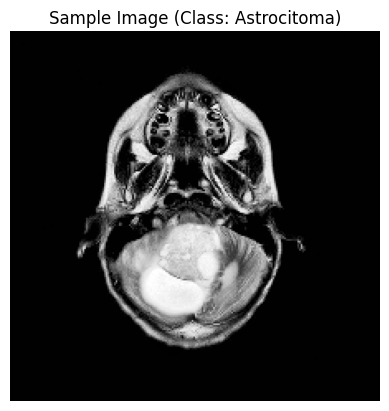

In [4]:
# Load and split the dataset
images, labels, class_names = load_dataset(base_dir) # Assign class_names
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42, stratify=labels
)

In [5]:
# Further split training data into training (80%) and validation (20%)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

In [6]:
# Print dataset shapes
print(f"Training Images Shape: {train_images.shape}")
print(f"Training Labels Shape: {train_labels.shape}")
print(f"Validation Images Shape: {val_images.shape}")
print(f"Validation Labels Shape: {val_labels.shape}")
print(f"Test Images Shape: {test_images.shape}")
print(f"Test Labels Shape: {test_labels.shape}")

Training Images Shape: (17920, 224, 224, 3)
Training Labels Shape: (17920,)
Validation Images Shape: (4480, 224, 224, 3)
Validation Labels Shape: (4480,)
Test Images Shape: (9600, 224, 224, 3)
Test Labels Shape: (9600,)


Visualize EDA


--- Dataset Overview ---
Total Images: 32000
Total Classes: 16
Class Distribution: [2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000
 2000 2000]

Class Names with Distribution:
                Class  Count
0         Astrocitoma   2000
1           Carcinoma   2000
2          Ependimoma   2000
3       Ganglioglioma   2000
4           Germinoma   2000
5        Glioblastoma   2000
6           Granuloma   2000
7      Meduloblastoma   2000
8         Neurocitoma   2000
9   Oligodendroglioma   2000
10           Papiloma   2000
11         Schwannoma   2000
12        Tuberculoma   2000
13         meningioma   2000
14          no tumour   2000
15          pituitary   2000


<ipython-input-3-5256aea907db>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution['Class'], y=class_distribution['Count'], palette="viridis")


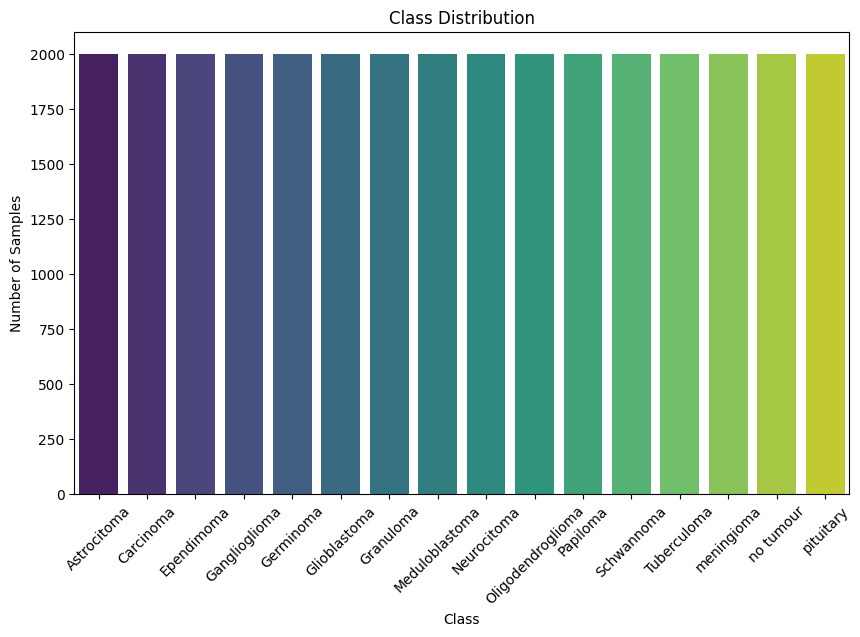


--- Displaying Sample Images from Each Class ---


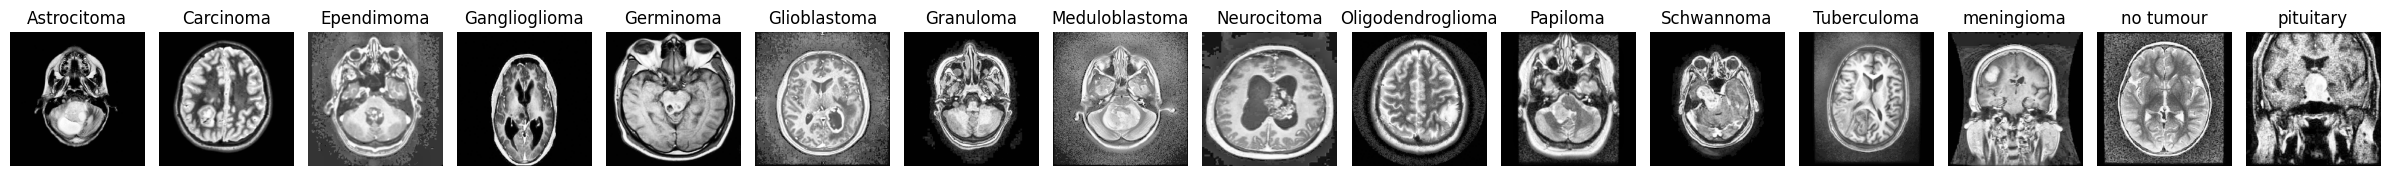


--- Image Shape and Value Distribution ---
Image Shape: (224, 224, 3)
Pixel Intensity Range: Min = 0.0, Max = 1.0


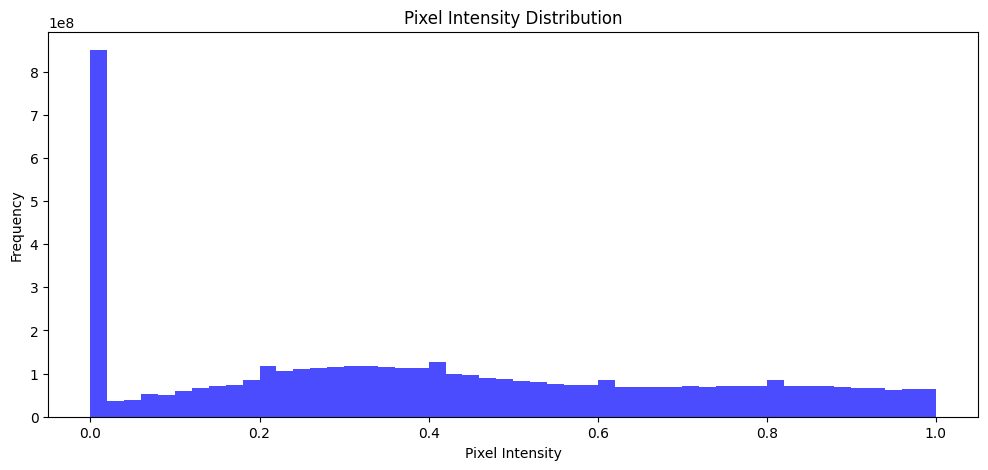


--- Checking Class Imbalance ---
Imbalance Ratio: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# Perform EDA on the dataset
perform_eda(images, labels, class_names)

Create the Hybrid Model [CNN and ViT (Vision Transformers) ]

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the Hybrid CNN + ViT Model
def create_hybrid_model(input_shape, num_classes, patch_size=32, embed_dim=64, num_heads=4, transformer_layers=4):
    """Builds a hybrid model combining CNN and Vision Transformer (ViT)."""

    # CNN Feature Extractor
    cnn_inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(cnn_inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)

    # Flatten CNN features before ViT processing
    cnn_features = layers.Flatten()(x)

    # Patch Embedding for ViT
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    patch_projection = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size, padding='valid')(cnn_inputs)
    patches = layers.Reshape((num_patches, embed_dim))(patch_projection)

    # Learnable positional embeddings
    positional_embedding = tf.Variable(tf.random.normal([1, num_patches, embed_dim]), trainable=True)

    # Use a Lambda layer to perform the broadcasting
    x = layers.Lambda(lambda inputs: inputs[0] + tf.broadcast_to(inputs[1], tf.shape(inputs[0])))([patches, positional_embedding])

    # Transformer Layers (ViT)
    for _ in range(transformer_layers):
        x_norm1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads)(x_norm1, x_norm1)
        x = layers.Add()([x, attention_output])
        x = layers.Dropout(0.1)(x)  # Dropout for better generalization

        x_norm2 = layers.LayerNormalization(epsilon=1e-6)(x)
        ff_output = layers.Dense(embed_dim * 2, activation='relu')(x_norm2)
        ff_output = layers.Dense(embed_dim)(ff_output)
        x = layers.Add()([x, ff_output])
        x = layers.Dropout(0.1)(x)  # Dropout again

    # Global average pooling to get ViT features
    vit_features = layers.GlobalAveragePooling1D()(x)

    # Concatenate CNN and ViT Features
    combined_features = layers.Concatenate()([cnn_features, vit_features])

    # Classification Head
    x = layers.Dense(256, activation='relu')(combined_features)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create Model
    model = models.Model(inputs=cnn_inputs, outputs=outputs)
    return model

hybrid_model = create_hybrid_model(input_shape=(224, 224, 3), num_classes=len(class_names))
hybrid_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Add callbacks to stop early if val_loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model with callbacks
history = hybrid_model.fit(train_images, train_labels,
                           validation_data=(val_images, val_labels),
                           epochs=10, batch_size=32, callbacks=[early_stopping, reduce_lr])


Epoch 1/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.5345 - loss: 1.6304 - val_accuracy: 0.9714 - val_loss: 0.0980 - learning_rate: 0.0010
Epoch 2/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9449 - loss: 0.1701 - val_accuracy: 0.9900 - val_loss: 0.0443 - learning_rate: 0.0010
Epoch 3/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9735 - loss: 0.0864 - val_accuracy: 0.9933 - val_loss: 0.0344 - learning_rate: 0.0010
Epoch 4/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9802 - loss: 0.0671 - val_accuracy: 0.9937 - val_loss: 0.0251 - learning_rate: 0.0010
Epoch 5/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9834 - loss: 0.0517 - val_accuracy: 0.9922 - val_loss: 0.0274 - learning_rate: 0.0010
Epoch 6/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9856 - loss: 0.0479 - val_accuracy: 0.9906 - val_loss: 0.0431 - learning_rate: 0.0010
Epoch 7/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9912 - l

In [23]:
# Evaluate the model
predictions = hybrid_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [32]:
# Classification Report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=class_names)) # Pass class_names as target_names

Classification Report:
                   precision    recall  f1-score   support

      Astrocitoma       0.98      0.99      0.99       600
        Carcinoma       1.00      1.00      1.00       600
       Ependimoma       1.00      1.00      1.00       600
    Ganglioglioma       1.00      1.00      1.00       600
        Germinoma       1.00      1.00      1.00       600
     Glioblastoma       1.00      1.00      1.00       600
        Granuloma       1.00      1.00      1.00       600
   Meduloblastoma       1.00      1.00      1.00       600
      Neurocitoma       0.99      0.99      0.99       600
Oligodendroglioma       1.00      1.00      1.00       600
         Papiloma       1.00      1.00      1.00       600
       Schwannoma       1.00      1.00      1.00       600
      Tuberculoma       1.00      1.00      1.00       600
       meningioma       0.98      0.94      0.96       600
        no tumour       0.98      0.97      0.97       600
        pituitary       0.96    

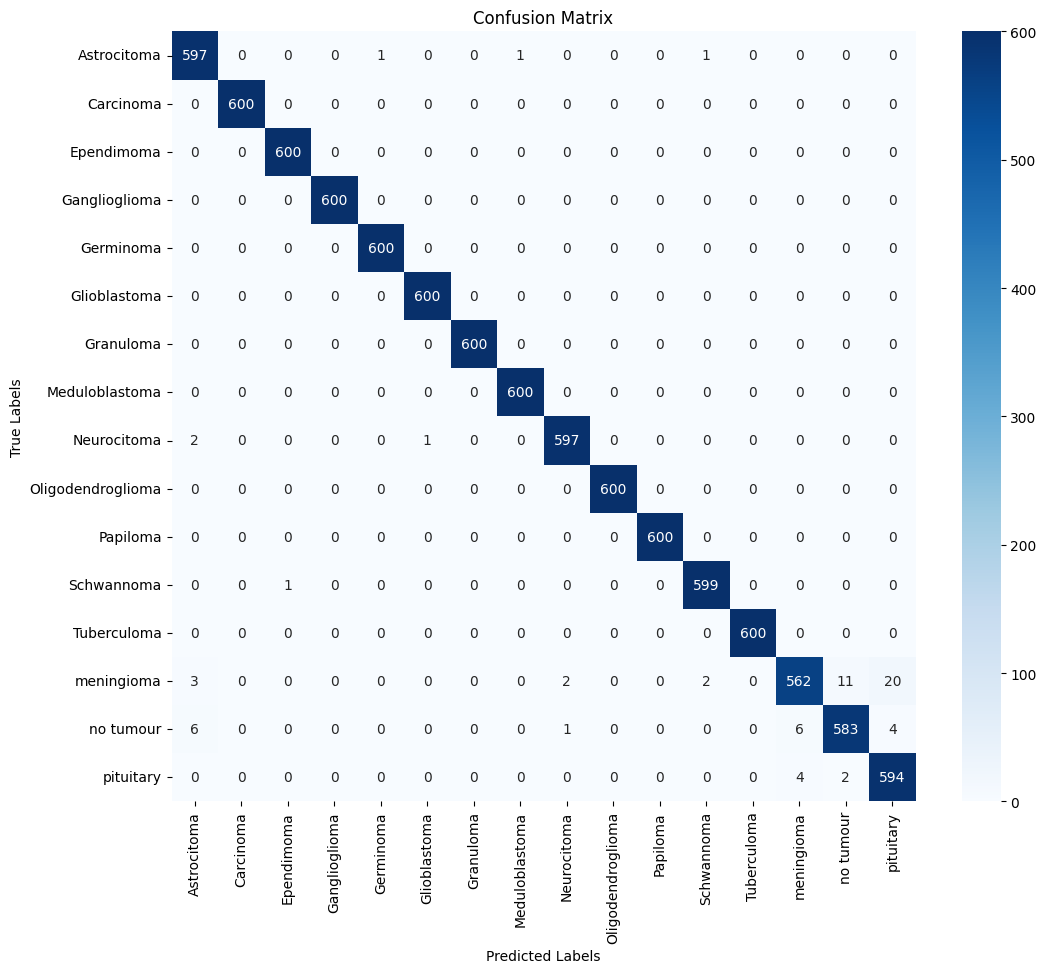

In [26]:
# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


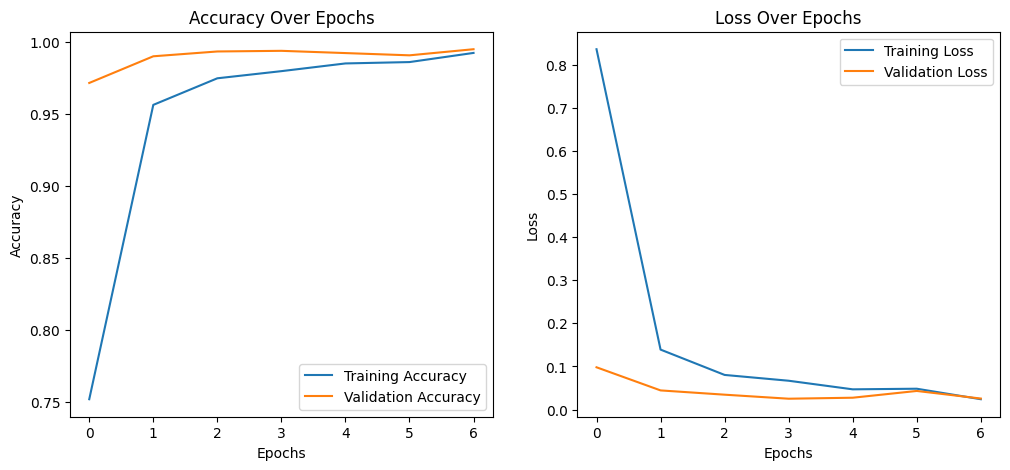

In [27]:
# Plot Training and Validation Metrics
def plot_metrics(history):
    """Plot training and validation metrics."""
    plt.figure(figsize=(12, 5))

    # Accuracy
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)


Average Classification Time per Tumor Class:
Class 0: 0.073805 seconds
Class 1: 0.074137 seconds
Class 2: 0.075410 seconds
Class 3: 0.074155 seconds
Class 4: 0.074033 seconds
Class 5: 0.073982 seconds
Class 6: 0.075158 seconds
Class 7: 0.073629 seconds
Class 8: 0.074529 seconds
Class 9: 0.073822 seconds
Class 10: 0.074301 seconds
Class 11: 0.074342 seconds
Class 12: 0.073825 seconds
Class 13: 0.074012 seconds
Class 14: 0.073486 seconds
Class 15: 0.074479 seconds


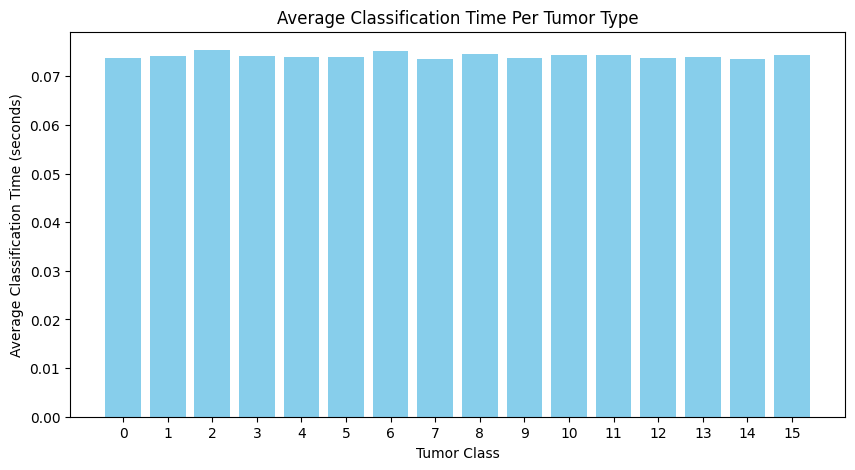

In [30]:
import time

# Dictionary to store time taken for each class
class_time = {label: [] for label in np.unique(labels)}

# Measure classification time for each test sample
for i, img in enumerate(test_images):
    start_time = time.time()  # Start timer
    pred = hybrid_model.predict(tf.expand_dims(img, axis=0), verbose=0)  # Get prediction
    end_time = time.time()  # End timer

    elapsed_time = end_time - start_time  # Compute time taken
    true_class = test_labels[i]  # Get true class label
    class_time[true_class].append(elapsed_time)  # Store time taken

# Compute average classification time per class
avg_time_per_class = {label: np.mean(times) for label, times in class_time.items()}

# Print results
print("\nAverage Classification Time per Tumor Class:")
for label, time_taken in avg_time_per_class.items():
    print(f"Class {label}: {time_taken:.6f} seconds")

# Plot classification time per class
plt.figure(figsize=(10, 5))
plt.bar(avg_time_per_class.keys(), avg_time_per_class.values(), color='skyblue')
plt.xlabel("Tumor Class")
plt.ylabel("Average Classification Time (seconds)")
plt.title("Average Classification Time Per Tumor Type")
plt.xticks(ticks=np.unique(labels))  # Set x-axis labels
plt.show()


In [33]:
hybrid_model.save('/content/drive/MyDrive/Colab Notebooks/Brain_Tumour_Classification_hybrid_model_Final(1).keras')